In [35]:
# Proyecto: Predicción de Ventas de Coches Eléctricos con XGBoost
# Autor: Tu nombre
# Dataset: Ventas mensuales de vehículos con variables económicas y ambientales

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# PASO 1: CARGAR Y EXPLORAR LOS DATOS
# =============================================================================

def cargar_datos():
    """Cargar el dataset desde el archivo CSV"""
    df = pd.read_excel('exports/ts_final.xlsx')
    
   # Crear columna de fecha usando método más directo
    df['fecha'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str) + '-01')
    
    # Ordenar por fecha
    df = df.sort_values('fecha').reset_index(drop=True)
    
    print("Dataset cargado exitosamente!")
    print(f"Forma del dataset: {df.shape}")
    print(f"Periodo: {df['fecha'].min()} a {df['fecha'].max()}")
    
    return df

In [37]:
def explorar_datos(df):
    """Exploración inicial del dataset"""
    print("\n" + "="*50)
    print("EXPLORACIÓN DE DATOS")
    print("="*50)
    
    print("\nPrimeras filas:")
    print(df.head())
    
    print("\nInformación del dataset:")
    print(df.info())
    
    print("\nEstadísticas descriptivas:")
    print(df.describe())
    
    print("\nValores nulos:")
    print(df.isnull().sum())
    
    # Visualizar evolución temporal de ventas eléctricas
    plt.figure(figsize=(12, 6))
    plt.plot(df['fecha'], df['ventas_electrico'], marker='o', linewidth=2)
    plt.title('Evolución de Ventas de Coches Eléctricos (2015-2023)', fontsize=14)
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Eléctricas')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df

In [39]:
# =============================================================================
# PASO 2: INGENIERÍA DE CARACTERÍSTICAS
# =============================================================================

def crear_caracteristicas(df):
    """Crear nuevas características para mejorar el modelo"""
    print("\n" + "="*50)
    print("INGENIERÍA DE CARACTERÍSTICAS")
    print("="*50)
    
    # Crear copia del dataframe
    df_features = df.copy()
    
    # 1. Características temporales
    df_features['año'] = df_features['fecha'].dt.year
    df_features['mes'] = df_features['fecha'].dt.month
    df_features['trimestre'] = df_features['fecha'].dt.quarter
    
    # 2. Características cíclicas (capturar estacionalidad)
    df_features['mes_sin'] = np.sin(2 * np.pi * df_features['mes'] / 12)
    df_features['mes_cos'] = np.cos(2 * np.pi * df_features['mes'] / 12)
    
    # 3. Lags (valores anteriores)
    df_features['ventas_electrico_lag1'] = df_features['ventas_electrico'].shift(1)
    df_features['ventas_electrico_lag2'] = df_features['ventas_electrico'].shift(2)
    df_features['ventas_electrico_lag3'] = df_features['ventas_electrico'].shift(3)
    
    # 4. Medias móviles
    df_features['ventas_electrico_ma3'] = df_features['ventas_electrico'].rolling(3).mean()
    df_features['ventas_electrico_ma6'] = df_features['ventas_electrico'].rolling(6).mean()
    
    # 5. Ratios importantes
    df_features['ratio_electrico_gasolina'] = df_features['ventas_electrico'] / (df_features['ventas_gasolina'] + 1)
    df_features['ratio_electrico_total'] = df_features['ventas_electrico'] / (
        df_features['ventas_gasolina'] + df_features['ventas_diesel'] + 
        df_features['ventas_electrico'] + df_features['ventas_otros'] + 1
    )
    
    # 6. Diferencias (cambios temporales)
    df_features['precio_gasolina_diff'] = df_features['precio_gasolina_eur_litro'].diff()
    df_features['incentivos_diff'] = df_features['ev_incentivos_mEur'].diff()
    
    # 7. Interacciones importantes
    df_features['incentivos_x_restricciones'] = df_features['ev_incentivos_mEur'] * df_features['restriccion_score']
    df_features['precio_x_pib'] = df_features['precio_gasolina_eur_litro'] * df_features['PIB_nominal']
    
    # 8. Tendencia temporal
    df_features['tendencia'] = range(len(df_features))
    
    print(f"Características creadas: {df_features.shape[1] - df.shape[1]} nuevas variables")
    print("Nuevas características:")
    nuevas_cols = [col for col in df_features.columns if col not in df.columns]
    for col in nuevas_cols:
        print(f"  - {col}")
    
    return df_features

def preparar_datos_modelo(df):
    """Preparar datos para el modelo XGBoost"""
    print("\n" + "="*50)
    print("PREPARACIÓN DE DATOS")
    print("="*50)
    
    # Eliminar filas con valores nulos (por los lags)
    df_clean = df.dropna().copy()
    
    # Definir variables objetivo y predictoras
    target = 'ventas_electrico'
    
    # Excluir columnas no relevantes para el modelo
    exclude_cols = ['fecha', 'ANO', 'MES', 'ventas_electrico', 'ventas_gasolina', 
                   'ventas_diesel', 'ventas_otros']  # Excluir otras ventas para evitar data leakage
    
    features = [col for col in df_clean.columns if col not in exclude_cols]
    
    X = df_clean[features]
    y = df_clean[target]
    
    print(f"Variables predictoras: {len(features)}")
    print("Lista de características:")
    for i, feature in enumerate(features, 1):
        print(f"  {i:2d}. {feature}")
    
    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    
    return X, y, features


In [41]:
# =============================================================================
# PASO 3: DIVISIÓN DE DATOS Y VALIDACIÓN
# =============================================================================

def dividir_datos(X, y, test_size=0.2, random_state=42):
    """Dividir datos en entrenamiento y prueba"""
    print("\n" + "="*50)
    print("DIVISIÓN DE DATOS")
    print("="*50)
    
    # Para series temporales, es mejor usar división temporal
    split_idx = int(len(X) * (1 - test_size))
    
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    print(f"Datos de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Datos de prueba: {X_test.shape[0]} muestras")
    print(f"Proporción de prueba: {len(X_test)/len(X):.2%}")
    
    return X_train, X_test, y_train, y_test


In [43]:
# =============================================================================
# PASO 4: ENTRENAMIENTO DEL MODELO XGBOOST
# =============================================================================

def entrenar_modelo_base(X_train, y_train):
    """Entrenar modelo XGBoost base"""
    print("\n" + "="*50)
    print("ENTRENAMIENTO MODELO BASE")
    print("="*50)
    
    # Parámetros base
    params_base = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'random_state': 42
    }
    
    # Entrenar modelo
    modelo_base = xgb.XGBRegressor(**params_base)
    modelo_base.fit(X_train, y_train)
    
    print("Modelo base entrenado exitosamente!")
    
    return modelo_base

def optimizar_hiperparametros(X_train, y_train):
    """Optimizar hiperparámetros usando GridSearchCV"""
    print("\n" + "="*50)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
    print("="*50)
    
    # Definir grilla de parámetros
    param_grid = {
        'max_depth': [3, 6, 9],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # Usar validación cruzada temporal
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Crear modelo base
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    
    # Grid search
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    print("Iniciando búsqueda de hiperparámetros...")
    grid_search.fit(X_train, y_train)
    
    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Mejor score: {-grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


In [45]:
# =============================================================================
# PASO 5: EVALUACIÓN DEL MODELO
# =============================================================================

def evaluar_modelo(modelo, X_train, X_test, y_train, y_test):
    """Evaluar el rendimiento del modelo"""
    print("\n" + "="*50)
    print("EVALUACIÓN DEL MODELO")
    print("="*50)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Métricas de entrenamiento
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Métricas de prueba
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    print("MÉTRICAS DE ENTRENAMIENTO:")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  R²:   {r2_train:.4f}")
    
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  R²:   {r2_test:.4f}")
    
    # Verificar overfitting
    print(f"\nDiferencia RMSE (train-test): {rmse_train - rmse_test:.2f}")
    if rmse_train < rmse_test * 0.8:
        print("⚠️  Posible overfitting detectado")
    else:
        print("✅ No hay signos evidentes de overfitting")
    
    return {
        'rmse_train': rmse_train, 'mae_train': mae_train, 'r2_train': r2_train,
        'rmse_test': rmse_test, 'mae_test': mae_test, 'r2_test': r2_test,
        'y_pred_train': y_pred_train, 'y_pred_test': y_pred_test
    }

def visualizar_resultados(modelo, X_train, X_test, y_train, y_test, metricas, features):
    """Visualizar resultados del modelo"""
    print("\n" + "="*50)
    print("VISUALIZACIÓN DE RESULTADOS")
    print("="*50)
    
    # Configurar subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Predicciones vs Valores reales
    axes[0,0].scatter(y_test, metricas['y_pred_test'], alpha=0.6)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales (R² = {metricas["r2_test"]:.3f})')
    
    # 2. Residuos
    residuos = y_test - metricas['y_pred_test']
    axes[0,1].scatter(metricas['y_pred_test'], residuos, alpha=0.6)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicciones')
    axes[0,1].set_ylabel('Residuos')
    axes[0,1].set_title('Análisis de Residuos')
    
    # 3. Importancia de características
    importancia = modelo.feature_importances_
    indices = np.argsort(importancia)[::-1][:10]  # Top 10
    
    axes[1,0].bar(range(10), importancia[indices])
    axes[1,0].set_xlabel('Características')
    axes[1,0].set_ylabel('Importancia')
    axes[1,0].set_title('Top 10 Características Más Importantes')
    axes[1,0].set_xticks(range(10))
    axes[1,0].set_xticklabels([features[i] for i in indices], rotation=45, ha='right')
    
    # 4. Evolución temporal
    # Combinar índices para visualización temporal
    train_idx = range(len(y_train))
    test_idx = range(len(y_train), len(y_train) + len(y_test))
    
    axes[1,1].plot(train_idx, y_train, label='Real (Train)', alpha=0.7)
    axes[1,1].plot(train_idx, metricas['y_pred_train'], label='Pred (Train)', alpha=0.7)
    axes[1,1].plot(test_idx, y_test, label='Real (Test)', alpha=0.7)
    axes[1,1].plot(test_idx, metricas['y_pred_test'], label='Pred (Test)', alpha=0.7)
    axes[1,1].axvline(x=len(y_train), color='red', linestyle='--', alpha=0.5, label='Train/Test Split')
    axes[1,1].set_xlabel('Tiempo')
    axes[1,1].set_ylabel('Ventas Eléctricas')
    axes[1,1].set_title('Evolución Temporal')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar importancia de características
    print("\nTOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
    for i, idx in enumerate(indices[:10], 1):
        print(f"{i:2d}. {features[idx]:<25} {importancia[idx]:.4f}")


In [47]:
# =============================================================================
# FUNCIÓN PRINCIPAL
# =============================================================================

def main():
    """Función principal del proyecto"""
    print("🚗 PREDICCIÓN DE VENTAS DE COCHES ELÉCTRICOS CON XGBOOST")
    print("="*60)
    
    # Paso 1: Cargar datos
    df = cargar_datos()
    df = explorar_datos(df)
    
    # Paso 2: Ingeniería de características
    df_features = crear_caracteristicas(df)
    X, y, features = preparar_datos_modelo(df_features)
    
    # Paso 3: Dividir datos
    X_train, X_test, y_train, y_test = dividir_datos(X, y)
    
    # Paso 4: Entrenar modelo base
    modelo_base = entrenar_modelo_base(X_train, y_train)
    
    # Evaluar modelo base
    print("\n🔍 EVALUACIÓN MODELO BASE:")
    metricas_base = evaluar_modelo(modelo_base, X_train, X_test, y_train, y_test)
    
    # Paso 5: Optimizar hiperparámetros
    print("\n🎯 OPTIMIZACIÓN DE HIPERPARÁMETROS:")
    modelo_optimizado = optimizar_hiperparametros(X_train, y_train)
    
    # Evaluar modelo optimizado
    print("\n📊 EVALUACIÓN MODELO OPTIMIZADO:")
    metricas_opt = evaluar_modelo(modelo_optimizado, X_train, X_test, y_train, y_test)
    
    # Visualizar resultados
    visualizar_resultados(modelo_optimizado, X_train, X_test, y_train, y_test, metricas_opt, features)
    
    # Comparar modelos
    print("\n" + "="*50)
    print("COMPARACIÓN DE MODELOS")
    print("="*50)
    print(f"Modelo Base - RMSE Test: {metricas_base['rmse_test']:.2f}, R²: {metricas_base['r2_test']:.4f}")
    print(f"Modelo Optimizado - RMSE Test: {metricas_opt['rmse_test']:.2f}, R²: {metricas_opt['r2_test']:.4f}")
    
    mejora_rmse = ((metricas_base['rmse_test'] - metricas_opt['rmse_test']) / metricas_base['rmse_test']) * 100
    print(f"Mejora en RMSE: {mejora_rmse:.2f}%")
    
    return modelo_optimizado, metricas_opt


In [49]:
# =============================================================================
# FUNCIONES ADICIONALES PARA PREDICCIÓN
# =============================================================================

def hacer_prediccion(modelo, X_nuevo):
    """Hacer predicciones con el modelo entrenado"""
    prediccion = modelo.predict(X_nuevo)
    return prediccion

def guardar_modelo(modelo, filename='modelo_xgboost_coches_electricos.pkl'):
    """Guardar el modelo entrenado"""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(modelo, f)
    print(f"Modelo guardado como: {filename}")

def cargar_modelo(filename='modelo_xgboost_coches_electricos.pkl'):
    """Cargar modelo previamente entrenado"""
    import pickle
    with open(filename, 'rb') as f:
        modelo = pickle.load(f)
    print(f"Modelo cargado desde: {filename}")
    return modelo

🚗 PREDICCIÓN DE VENTAS DE COCHES ELÉCTRICOS CON XGBOOST
Dataset cargado exitosamente!
Forma del dataset: (108, 11)
Periodo: 2015-01-01 00:00:00 a 2023-12-01 00:00:00

EXPLORACIÓN DE DATOS

Primeras filas:
    ANO  MES  ventas_gasolina  ventas_diesel  ventas_electrico  ventas_otros  \
0  2015    1            22787          48250                55             0   
1  2015    2            31283          58821                51             0   
2  2015    3            42380          73040               162             0   
3  2015    4            31291          54507               111             0   
4  2015    5            36275          61082               118             0   

    PIB_nominal  precio_gasolina_eur_litro  ev_incentivos_mEur  \
0  1.206165e+12                   1.130435                 0.0   
1  1.206165e+12                   1.187365                 0.0   
2  1.206165e+12                   1.258910                 0.0   
3  1.206165e+12                   1.285613        

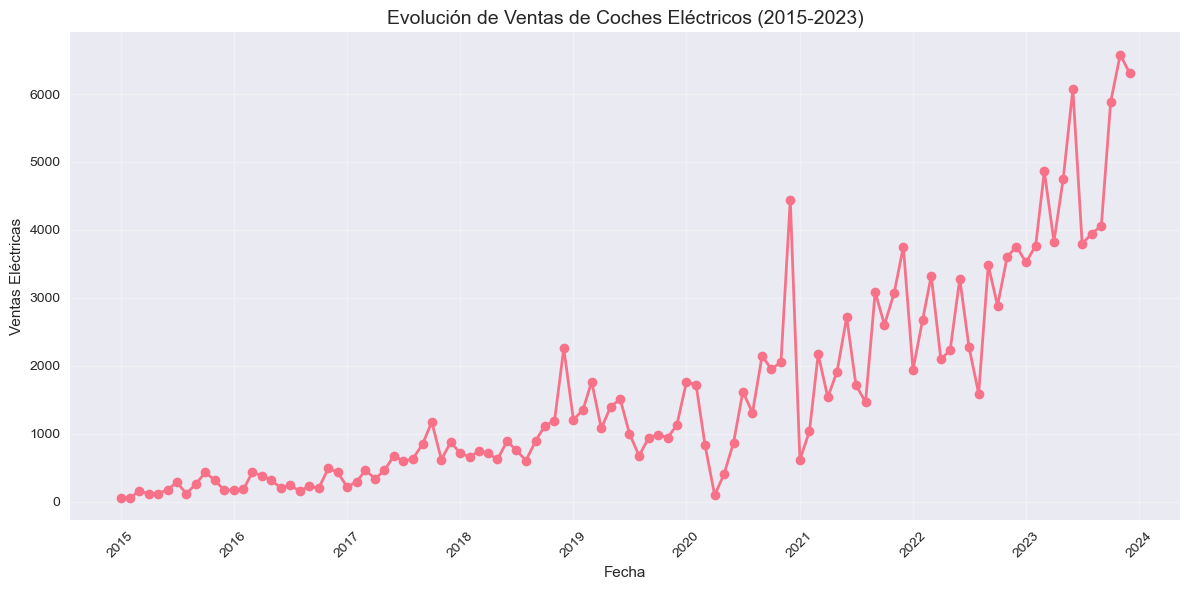


INGENIERÍA DE CARACTERÍSTICAS
Características creadas: 17 nuevas variables
Nuevas características:
  - año
  - mes
  - trimestre
  - mes_sin
  - mes_cos
  - ventas_electrico_lag1
  - ventas_electrico_lag2
  - ventas_electrico_lag3
  - ventas_electrico_ma3
  - ventas_electrico_ma6
  - ratio_electrico_gasolina
  - ratio_electrico_total
  - precio_gasolina_diff
  - incentivos_diff
  - incentivos_x_restricciones
  - precio_x_pib
  - tendencia

PREPARACIÓN DE DATOS
Variables predictoras: 21
Lista de características:
   1. PIB_nominal
   2. precio_gasolina_eur_litro
   3. ev_incentivos_mEur
   4. restriccion_score
   5. año
   6. mes
   7. trimestre
   8. mes_sin
   9. mes_cos
  10. ventas_electrico_lag1
  11. ventas_electrico_lag2
  12. ventas_electrico_lag3
  13. ventas_electrico_ma3
  14. ventas_electrico_ma6
  15. ratio_electrico_gasolina
  16. ratio_electrico_total
  17. precio_gasolina_diff
  18. incentivos_diff
  19. incentivos_x_restricciones
  20. precio_x_pib
  21. tendencia

Form

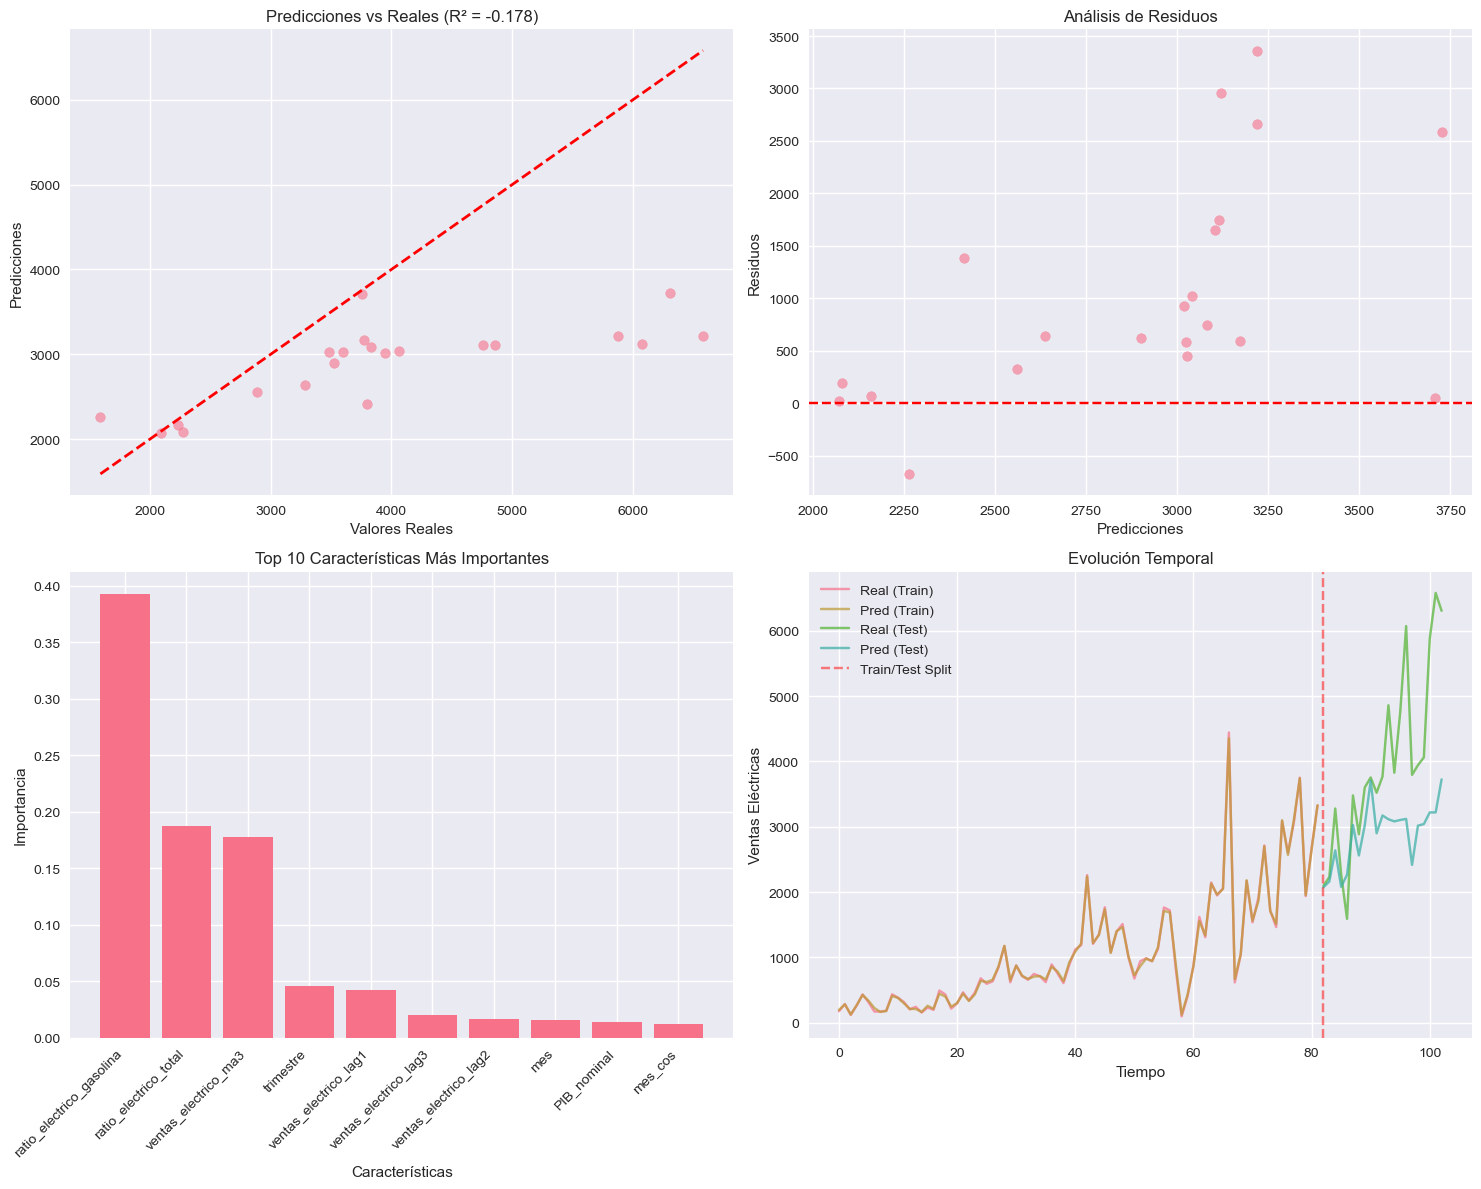


TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
 1. ratio_electrico_gasolina  0.3925
 2. ratio_electrico_total     0.1869
 3. ventas_electrico_ma3      0.1775
 4. trimestre                 0.0458
 5. ventas_electrico_lag1     0.0418
 6. ventas_electrico_lag3     0.0196
 7. ventas_electrico_lag2     0.0161
 8. mes                       0.0154
 9. PIB_nominal               0.0133
10. mes_cos                   0.0122

COMPARACIÓN DE MODELOS
Modelo Base - RMSE Test: 1475.11, R²: -0.1648
Modelo Optimizado - RMSE Test: 1483.55, R²: -0.1781
Mejora en RMSE: -0.57%
Modelo guardado como: modelo_xgboost_coches_electricos.pkl

🎉 PROYECTO COMPLETADO EXITOSAMENTE!
El modelo XGBoost ha sido entrenado y optimizado.
Puedes usar 'hacer_prediccion()' para nuevas predicciones.


In [51]:
# =============================================================================
# EJECUTAR PROYECTO
# =============================================================================

if __name__ == "__main__":
    # Ejecutar el proyecto completo
    modelo_final, metricas_finales = main()
    
    # Guardar modelo
    guardar_modelo(modelo_final)
    
    print("\n🎉 PROYECTO COMPLETADO EXITOSAMENTE!")
    print("El modelo XGBoost ha sido entrenado y optimizado.")
    print("Puedes usar 'hacer_prediccion()' para nuevas predicciones.")

In [62]:
# Proyecto: Predicción de Ventas de Coches Eléctricos con XGBoost (MEJORADO)
# Soluciones a los problemas identificados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def cargar_datos():
    """Cargar el dataset desde el archivo CSV"""
    df = pd.read_excel('exports/ts_final.xlsx')
    df['fecha'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str) + '-01')
    df = df.sort_values('fecha').reset_index(drop=True)
    
    print("Dataset cargado exitosamente!")
    print(f"Forma del dataset: {df.shape}")
    print(f"Periodo: {df['fecha'].min()} a {df['fecha'].max()}")
    
    return df

def crear_caracteristicas_mejoradas(df):
    """Crear características SIN data leakage"""
    print("\n" + "="*50)
    print("INGENIERÍA DE CARACTERÍSTICAS MEJORADAS")
    print("="*50)
    
    df_features = df.copy()
    
    # 1. Características temporales (OK)
    df_features['año'] = df_features['fecha'].dt.year
    df_features['mes'] = df_features['fecha'].dt.month
    df_features['trimestre'] = df_features['fecha'].dt.quarter
    
    # 2. Características cíclicas (OK)
    df_features['mes_sin'] = np.sin(2 * np.pi * df_features['mes'] / 12)
    df_features['mes_cos'] = np.cos(2 * np.pi * df_features['mes'] / 12)
    
    # 3. Lags de variables EXÓGENAS (no de la variable objetivo)
    df_features['precio_gasolina_lag1'] = df_features['precio_gasolina_eur_litro'].shift(1)
    df_features['precio_gasolina_lag2'] = df_features['precio_gasolina_eur_litro'].shift(2)
    df_features['incentivos_lag1'] = df_features['ev_incentivos_mEur'].shift(1)
    df_features['incentivos_lag2'] = df_features['ev_incentivos_mEur'].shift(2)
    
    # 4. Medias móviles de variables EXÓGENAS
    df_features['precio_gasolina_ma3'] = df_features['precio_gasolina_eur_litro'].rolling(3).mean()
    df_features['incentivos_ma3'] = df_features['ev_incentivos_mEur'].rolling(3).mean()
    
    # 5. Solo LAGS de la variable objetivo (información del pasado)
    df_features['ventas_electrico_lag1'] = df_features['ventas_electrico'].shift(1)
    df_features['ventas_electrico_lag2'] = df_features['ventas_electrico'].shift(2)
    df_features['ventas_electrico_lag3'] = df_features['ventas_electrico'].shift(3)
    
    # 6. Diferencias (cambios temporales)
    df_features['precio_gasolina_diff'] = df_features['precio_gasolina_eur_litro'].diff()
    df_features['incentivos_diff'] = df_features['ev_incentivos_mEur'].diff()
    df_features['restriccion_diff'] = df_features['restriccion_score'].diff()
    
    # 7. Interacciones relevantes
    df_features['incentivos_x_restricciones'] = (df_features['ev_incentivos_mEur'] * 
                                                df_features['restriccion_score'])
    df_features['precio_x_pib'] = (df_features['precio_gasolina_eur_litro'] * 
                                  df_features['PIB_nominal'] / 1e12)  # Normalizar PIB
    
    # 8. Tendencia temporal
    df_features['tendencia'] = range(len(df_features))
    df_features['tendencia_cuadratica'] = df_features['tendencia'] ** 2
    
    # 9. Ratios históricos de mercado (sin incluir ventas_electrico actual)
    df_features['ventas_total_otros'] = (df_features['ventas_gasolina'] + 
                                        df_features['ventas_diesel'] + 
                                        df_features['ventas_otros'])
    
    # 10. Normalizar PIB (muy importante)
    df_features['PIB_normalizado'] = df_features['PIB_nominal'] / 1e12
    
    print(f"Características creadas: {df_features.shape[1] - df.shape[1]} nuevas variables")
    
    return df_features

def preparar_datos_modelo_mejorado(df):
    """Preparar datos eliminando variables con data leakage"""
    print("\n" + "="*50)
    print("PREPARACIÓN DE DATOS MEJORADA")
    print("="*50)
    
    # Eliminar más filas con NaN para tener datos más limpios
    df_clean = df.dropna().copy()
    
    target = 'ventas_electrico'
    
    # IMPORTANTE: Excluir variables que pueden causar data leakage
    exclude_cols = [
        'fecha', 'ANO', 'MES', 'ventas_electrico',
        'ventas_gasolina', 'ventas_diesel', 'ventas_otros',  # Otras ventas
        'PIB_nominal',  # Usar la versión normalizada
        'ventas_total_otros'  # Era solo para crear otras variables
    ]
    
    features = [col for col in df_clean.columns if col not in exclude_cols]
    
    X = df_clean[features]
    y = df_clean[target]
    
    print(f"Variables predictoras: {len(features)}")
    print("Lista de características:")
    for i, feature in enumerate(features, 1):
        print(f"  {i:2d}. {feature}")
    
    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    
    return X, y, features

def entrenar_modelo_robusto(X, y, test_size=0.2):
    """Entrenar modelo con mejor configuración"""
    print("\n" + "="*50)
    print("ENTRENAMIENTO MODELO ROBUSTO")
    print("="*50)
    
    # División temporal
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Escalado de características (importante para XGBoost con datos muy diferentes)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convertir de vuelta a DataFrame para mantener nombres
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    print(f"Datos de entrenamiento: {X_train.shape[0]} muestras")
    print(f"Datos de prueba: {X_test.shape[0]} muestras")
    
    # Configuración más conservadora para evitar overfitting
    params_robustos = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 4,  # Más conservador
        'learning_rate': 0.05,  # Más lento
        'n_estimators': 200,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,  # Regularización L1
        'reg_lambda': 0.1,  # Regularización L2
        'random_state': 42
    }
    
    # Entrenar modelo
    modelo = xgb.XGBRegressor(**params_robustos,
                             early_stopping_rounds=20)
    
    # Usar early stopping para evitar overfitting
    modelo.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )
    
    return modelo, scaler, X_train_scaled, X_test_scaled, y_train, y_test

def evaluar_modelo_completo(modelo, scaler, X_train, X_test, y_train, y_test, features):
    """Evaluación completa del modelo"""
    print("\n" + "="*50)
    print("EVALUACIÓN COMPLETA")
    print("="*50)
    
    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Métricas
    metrics = {
        'rmse_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'mae_train': mean_absolute_error(y_train, y_pred_train),
        'r2_train': r2_score(y_train, y_pred_train),
        'rmse_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'mae_test': mean_absolute_error(y_test, y_pred_test),
        'r2_test': r2_score(y_test, y_pred_test)
    }
    
    print("MÉTRICAS DE ENTRENAMIENTO:")
    print(f"  RMSE: {metrics['rmse_train']:.2f}")
    print(f"  MAE:  {metrics['mae_train']:.2f}")
    print(f"  R²:   {metrics['r2_train']:.4f}")
    
    print("\nMÉTRICAS DE PRUEBA:")
    print(f"  RMSE: {metrics['rmse_test']:.2f}")
    print(f"  MAE:  {metrics['mae_test']:.2f}")
    print(f"  R²:   {metrics['r2_test']:.4f}")
    
    # Análisis de overfitting
    overfitting_ratio = metrics['rmse_train'] / metrics['rmse_test']
    print(f"\nRatio RMSE (train/test): {overfitting_ratio:.2f}")
    
    if overfitting_ratio < 0.7:
        print("⚠️  Posible overfitting detectado")
    elif overfitting_ratio > 1.3:
        print("⚠️  Posible underfitting detectado")
    else:
        print("✅ Balance adecuado train/test")
    
    # Importancia de características
    importancia = modelo.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': importancia
    }).sort_values('importance', ascending=False)
    
    print("\nTOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<30} {row['importance']:.4f}")
    
    return metrics, feature_importance

def visualizar_resultados_mejorados(modelo, X_train, X_test, y_train, y_test, 
                                   feature_importance, metrics):
    """Visualización mejorada de resultados"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Predicciones vs Reales
    y_pred_test = modelo.predict(X_test)
    axes[0,0].scatter(y_test, y_pred_test, alpha=0.7, s=60)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales\n(R² = {metrics["r2_test"]:.3f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Residuos
    residuos = y_test - y_pred_test
    axes[0,1].scatter(y_pred_test, residuos, alpha=0.7, s=60)
    axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0,1].set_xlabel('Predicciones')
    axes[0,1].set_ylabel('Residuos')
    axes[0,1].set_title('Análisis de Residuos')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Importancia de características
    top_features = feature_importance.head(10)
    axes[1,0].barh(range(len(top_features)), top_features['importance'])
    axes[1,0].set_yticks(range(len(top_features)))
    axes[1,0].set_yticklabels(top_features['feature'])
    axes[1,0].set_xlabel('Importancia')
    axes[1,0].set_title('Top 10 Características Más Importantes')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Evolución temporal
    train_idx = range(len(y_train))
    test_idx = range(len(y_train), len(y_train) + len(y_test))
    
    y_pred_train = modelo.predict(X_train)
    
    axes[1,1].plot(train_idx, y_train, 'b-', label='Real (Train)', alpha=0.7, linewidth=2)
    axes[1,1].plot(train_idx, y_pred_train, 'b--', label='Pred (Train)', alpha=0.7, linewidth=2)
    axes[1,1].plot(test_idx, y_test, 'r-', label='Real (Test)', alpha=0.7, linewidth=2)
    axes[1,1].plot(test_idx, y_pred_test, 'r--', label='Pred (Test)', alpha=0.7, linewidth=2)
    axes[1,1].axvline(x=len(y_train), color='orange', linestyle=':', alpha=0.8, linewidth=2)
    axes[1,1].set_xlabel('Índice Temporal')
    axes[1,1].set_ylabel('Ventas Eléctricas')
    axes[1,1].set_title('Evolución Temporal')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main_mejorado():
    """Función principal mejorada"""
    print("🚗 PREDICCIÓN DE VENTAS DE COCHES ELÉCTRICOS - VERSIÓN MEJORADA")
    print("="*70)
    
    # Cargar datos
    df = cargar_datos()
    
    # Crear características sin data leakage
    df_features = crear_caracteristicas_mejoradas(df)
    
    # Preparar datos
    X, y, features = preparar_datos_modelo_mejorado(df_features)
    
    # Entrenar modelo robusto
    modelo, scaler, X_train, X_test, y_train, y_test = entrenar_modelo_robusto(X, y)
    
    # Evaluar modelo
    metrics, feature_importance = evaluar_modelo_completo(
        modelo, scaler, X_train, X_test, y_train, y_test, features
    )
    
    # Visualizar resultados
    visualizar_resultados_mejorados(
        modelo, X_train, X_test, y_train, y_test, feature_importance, metrics
    )
    
    print("\n🎉 ANÁLISIS COMPLETADO CON MEJORAS!")
    print("Principales cambios implementados:")
    print("✅ Eliminado data leakage")
    print("✅ Regularización añadida")
    print("✅ Early stopping implementado")
    print("✅ Normalización de características")
    print("✅ Parámetros más conservadores")
    
    return modelo, scaler, metrics, feature_importance

🚗 PREDICCIÓN DE VENTAS DE COCHES ELÉCTRICOS - VERSIÓN MEJORADA
Dataset cargado exitosamente!
Forma del dataset: (108, 11)
Periodo: 2015-01-01 00:00:00 a 2023-12-01 00:00:00

INGENIERÍA DE CARACTERÍSTICAS MEJORADAS
Características creadas: 23 nuevas variables

PREPARACIÓN DE DATOS MEJORADA
Variables predictoras: 25
Lista de características:
   1. precio_gasolina_eur_litro
   2. ev_incentivos_mEur
   3. restriccion_score
   4. año
   5. mes
   6. trimestre
   7. mes_sin
   8. mes_cos
   9. precio_gasolina_lag1
  10. precio_gasolina_lag2
  11. incentivos_lag1
  12. incentivos_lag2
  13. precio_gasolina_ma3
  14. incentivos_ma3
  15. ventas_electrico_lag1
  16. ventas_electrico_lag2
  17. ventas_electrico_lag3
  18. precio_gasolina_diff
  19. incentivos_diff
  20. restriccion_diff
  21. incentivos_x_restricciones
  22. precio_x_pib
  23. tendencia
  24. tendencia_cuadratica
  25. PIB_normalizado

Forma de X: (105, 25)
Forma de y: (105,)

ENTRENAMIENTO MODELO ROBUSTO
Datos de entrenamiento:

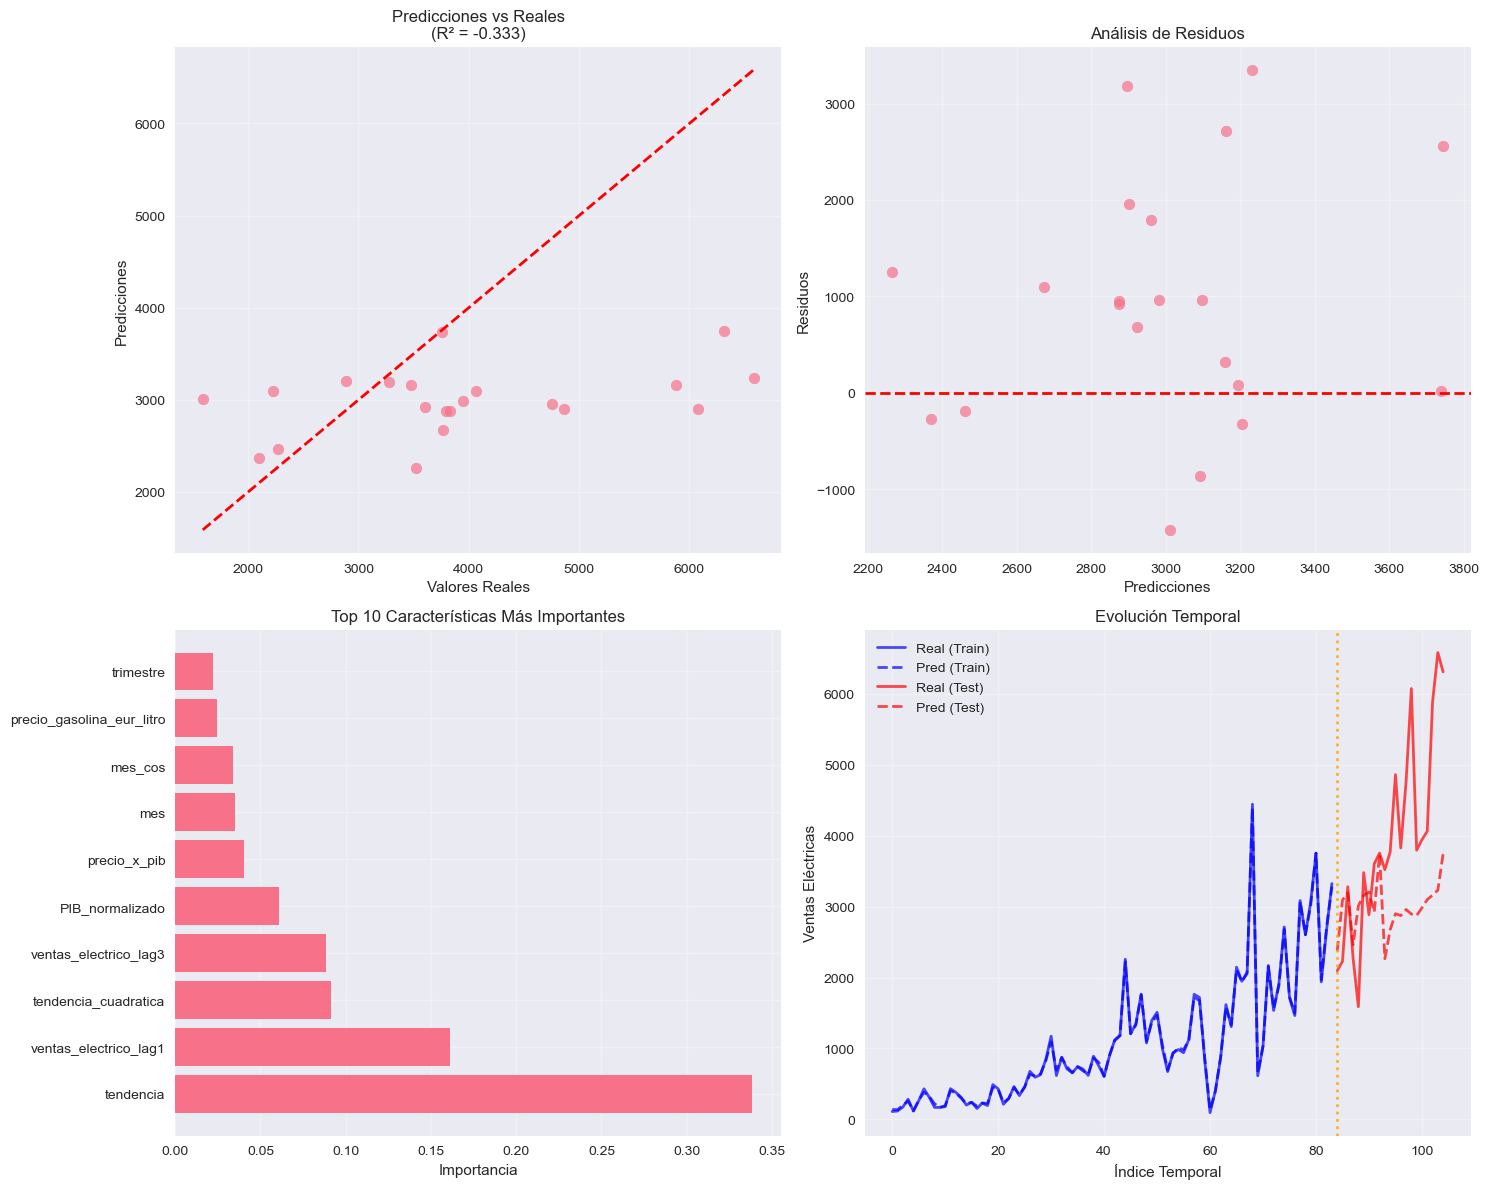


🎉 ANÁLISIS COMPLETADO CON MEJORAS!
Principales cambios implementados:
✅ Eliminado data leakage
✅ Regularización añadida
✅ Early stopping implementado
✅ Normalización de características
✅ Parámetros más conservadores


In [64]:
if __name__ == "__main__":
    modelo, scaler, metrics, importance = main_mejorado()

In [70]:
from prophet import Prophet
import pandas as pd

# 1. Prepara los datos para Prophet
# Prophet necesita las columnas con nombres específicos: 'ds' para la fecha y 'y' para el valor a predecir.
df_prophet = df.rename(columns={'fecha': 'ds', 'ventas_electrico': 'y'})

# Selecciona las columnas que usarás
# 'ds', 'y' y tus variables externas (regresores)
df_prophet = df_prophet[['ds', 'y', 'PIB_nominal', 'precio_gasolina_eur_litro', 'ev_incentivos_mEur', 'restriccion_score']]

# 2. Divide en entrenamiento y prueba (manteniendo el orden cronológico)
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

# 3. Inicializa y configura el modelo
# Le decimos al modelo que queremos una estacionalidad anual
model = Prophet(yearly_seasonality=True)

# Añade tus variables externas como regresores
model.add_regressor('PIB_nominal')
model.add_regressor('precio_gasolina_eur_litro')
model.add_regressor('ev_incentivos_mEur')
model.add_regressor('restriccion_score')

# 4. Entrena el modelo
model.fit(train_df)

# 5. Realiza la predicción
# 'future' dataframe debe contener las fechas y los valores de los regresores para el período de predicción.
future = test_df.drop(columns='y')
forecast = model.predict(future)

# 6. Evalúa los resultados
# Compara 'forecast['yhat']' (predicción) con 'test_df['y']' (valor real)
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_df['y'], forecast['yhat'])
rmse = mean_squared_error(test_df['y'], forecast['yhat'], squared=False)

print(f"R² en el conjunto de prueba: {r2:.4f}")
print(f"RMSE en el conjunto de prueba: {rmse:.2f}")

# Prophet también ofrece gráficos muy útiles
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

NameError: name 'df' is not defined

Cargando y preparando los datos...
Datos preparados exitosamente.
Periodo total de datos: 2015-01-01 a 2023-12-01

Datos de entrenamiento: 86 muestras (2015-01-01 a 2022-02-01)
Datos de prueba: 22 muestras (2022-03-01 a 2023-12-01)

Entrenando el modelo Prophet...


15:47:58 - cmdstanpy - INFO - Chain [1] start processing
15:47:58 - cmdstanpy - INFO - Chain [1] done processing


Modelo entrenado.

Realizando predicciones en el conjunto de prueba...

Evaluando el rendimiento del modelo...
  -> R² (Coeficiente de Determinación): -0.2678
  -> RMSE (Error Cuadrático Medio Raíz): 1510.29

Generando visualizaciones...


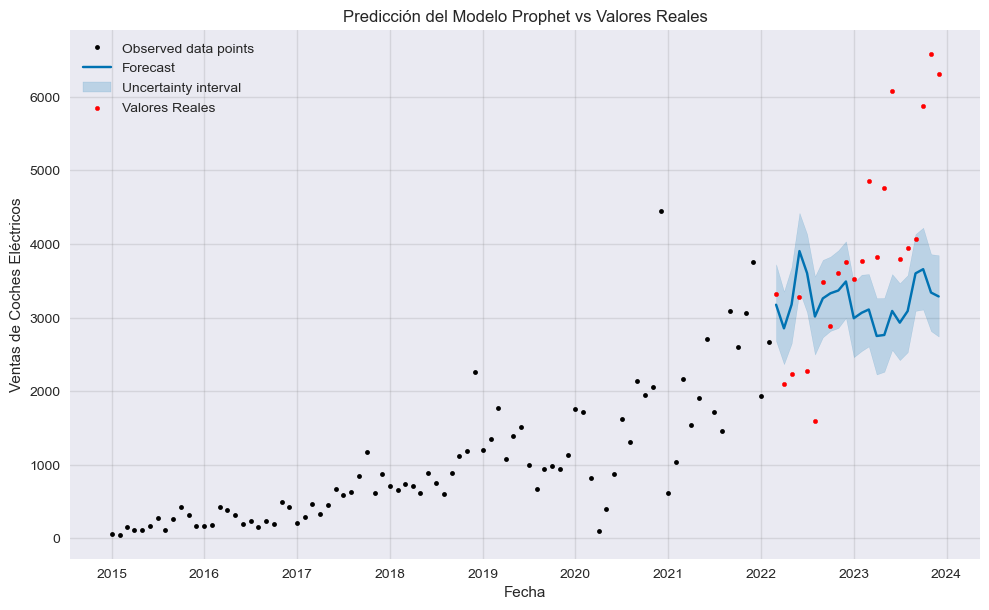

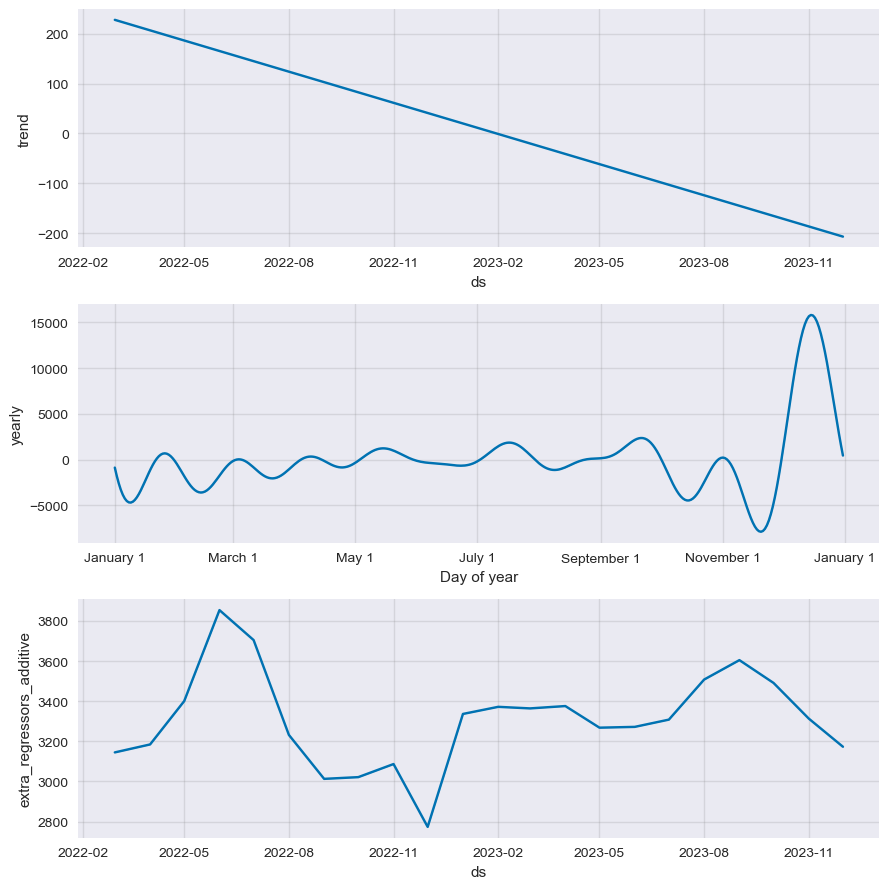


¡Proceso completado!


In [72]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# =============================================================================
# PASO 1: CARGAR Y PREPARAR LOS DATOS
# =============================================================================
print("Cargando y preparando los datos...")

# Cargar el dataset desde el archivo CSV
try:
    df = pd.read_excel('exports/ts_final.xlsx')
except FileNotFoundError:
    print("Error: Asegúrate de que tu archivo de datos se llame 'tu_archivo.csv' y esté en la misma carpeta.")
    exit()

# Crear una columna de fecha combinando AÑO y MES
df['fecha'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str) + '-01')

# Prophet requiere nombres de columna específicos: 'ds' para la fecha y 'y' para el valor a predecir
df_prophet = df.rename(columns={'fecha': 'ds', 'ventas_electrico': 'y'})

# Seleccionar las columnas que usaremos: ds, y, y las variables externas (regresores)
regressors = [
    'PIB_nominal',
    'precio_gasolina_eur_litro',
    'ev_incentivos_mEur',
    'restriccion_score'
]
df_prophet = df_prophet[['ds', 'y'] + regressors]

print("Datos preparados exitosamente.")
print(f"Periodo total de datos: {df_prophet['ds'].min().date()} a {df_prophet['ds'].max().date()}")

# =============================================================================
# PASO 2: DIVIDIR EN CONJUNTO DE ENTRENAMIENTO Y PRUEBA
# =============================================================================
# Mantener el orden cronológico para la división
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

print(f"\nDatos de entrenamiento: {train_df.shape[0]} muestras ({train_df['ds'].min().date()} a {train_df['ds'].max().date()})")
print(f"Datos de prueba: {test_df.shape[0]} muestras ({test_df['ds'].min().date()} a {test_df['ds'].max().date()})")

# =============================================================================
# PASO 3: INICIALIZAR, CONFIGURAR Y ENTRENAR EL MODELO
# =============================================================================
print("\nEntrenando el modelo Prophet...")

# Inicializar el modelo. La estacionalidad anual es adecuada para datos mensuales.
# Se pueden ajustar otros parámetros como changepoint_prior_scale para controlar la flexibilidad de la tendencia.
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Añadir las variables externas como regresores
for regressor in regressors:
    model.add_regressor(regressor)

# Entrenar el modelo con los datos de entrenamiento
model.fit(train_df)

print("Modelo entrenado.")

# =============================================================================
# PASO 4: REALIZAR PREDICCIONES
# =============================================================================
print("\nRealizando predicciones en el conjunto de prueba...")

# El dataframe 'future' debe contener las fechas del futuro y los valores de los regresores para ese período.
# La forma más sencilla es usar el propio conjunto de prueba, ya que contiene esta información.
future = test_df.drop(columns='y')

# Realizar la predicción
forecast = model.predict(future)

# `forecast` contiene muchas columnas, pero las más importantes son:
# 'yhat': la predicción
# 'yhat_lower' y 'yhat_upper': el intervalo de incertidumbre

# =============================================================================
# PASO 5: EVALUAR EL RENDIMIENTO DEL MODELO
# =============================================================================
print("\nEvaluando el rendimiento del modelo...")

# Extraer los valores reales y predichos
y_true = test_df['y']
y_pred = forecast['yhat']

# Calcular métricas
r2 = r2_score(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"  -> R² (Coeficiente de Determinación): {r2:.4f}")
print(f"  -> RMSE (Error Cuadrático Medio Raíz): {rmse:.2f}")

# =============================================================================
# PASO 6: VISUALIZAR LOS RESULTADOS
# =============================================================================
print("\nGenerando visualizaciones...")

# Gráfico 1: Predicción vs Valores Reales
fig1 = model.plot(forecast)
plt.scatter(test_df['ds'], test_df['y'], c='r', s=10, label='Valores Reales')
plt.legend()
plt.title('Predicción del Modelo Prophet vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Ventas de Coches Eléctricos')
plt.show()

# Gráfico 2: Componentes del Modelo
# Muestra la tendencia, estacionalidad y el efecto de los regresores
fig2 = model.plot_components(forecast)
plt.show()

print("\n¡Proceso completado!")